# QCoDeS example with Textronix DPO 7200xx scopes 


In [1]:
from qcodes.dataset.measurements import Measurement
from qcodes.dataset.plotting import plot_by_id
from qcodes.dataset.experiment_container import new_experiment

from qcodes.instrument_drivers.tektronix.DPO7200xx import TektronixDPO7000xx

In [2]:
tek = TektronixDPO7000xx("tek3", "TCPIP0::10.193.36.56::inst0::INSTR")

Connected to: TEKTRONIX DPO72004C (serial:C600651, firmware:CF:91.1CT FV:10.8.3 Build 3) in 0.38s


In [3]:
experiment = new_experiment(name='DPO_72000_example', sample_name="no sample")

## Aqcuiring traces 

In [4]:
# First, determine the number of samples we wish to acquire
tek.channel[0].set_trace_length(1000)
# alternatively, we can set the time over which we 
# wish to acquire a trace (uncomment the following line): 
# tek.channel[0].set_trace_time(4E-3)

Starting experimental run with id: 6


([<matplotlib.axes._subplots.AxesSubplot at 0x1a3820cef60>,
 [None, None])

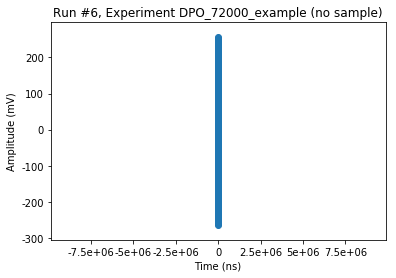

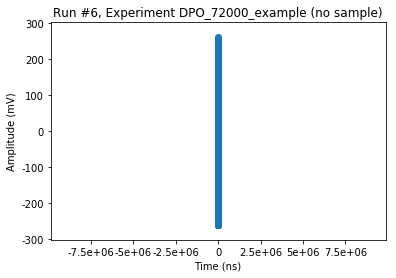

In [5]:
meas = Measurement(exp=experiment)
meas.register_parameter(tek.channel[0].waveform.trace)
meas.register_parameter(tek.channel[1].waveform.trace)

with meas.run() as datasaver:
    for i in [0, 1]:
        datasaver.add_result(
            (tek.channel[i].waveform.trace_axis, tek.channel[i].waveform.trace_axis()),
            (tek.channel[i].waveform.trace, tek.channel[i].waveform.trace())
        )

    dataid = datasaver.run_id

plot_by_id(dataid)

There seems to be something wrong with the `plot_by_id` method. Fixing this is beyond the scope of this PR. Below we show that the driver works properly 

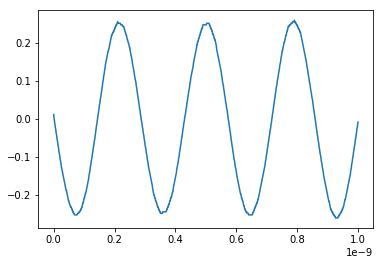

In [6]:
import matplotlib.pyplot as plt 
plt.plot(
    tek.channel[i].waveform.trace_axis(), 
    tek.channel[i].waveform.trace()
)

## Changing the waveform format 

If we wish, we can change the way in which data is retrieved from the instrument, which can enhance the precision of the data and the speed to retrieval. 

We do this through the 'waveform' module on the main driver (e.g. `tek.waveform`) as opposed to the 'waveform' module on a channel (e.g. `tek.channel[0].waveform`). We have this distinction because the waveform formatting parameters effect all waveform sources (e.g. channel 0 or channel 1) 

In [7]:
tek.waveform.data_format()

'signed_integer'

In [8]:
# The available formats 
tek.waveform.data_format.vals

<Enum: {'signed_integer', 'unsigned_integer', 'floating_point'}>

In [9]:
tek.waveform.is_big_endian()

True

In [10]:
tek.waveform.bytes_per_sample()

1

In [11]:
tek.waveform.bytes_per_sample.vals

<Enum: {8, 1, 2, 4}>

In [12]:
tek.waveform.is_binary()
# Setting is_binary to false will trasfer data in ascii mode. 

True

## Trigger setup 

The `tek.trigger` module is the 'main' trigger

In [13]:
tek.trigger.source()

'CH1'

In [14]:
tek.trigger.trigger_type()

'edge'

In [15]:
tek.trigger.edge_slope()

'fall'

In [16]:
tek.trigger.edge_slope("rise")

### Delayed trigger 

You can trigger with the Main trigger system alone or combine the Main trigger with the Delayed trigger to trigger on sequential events. When using sequential triggering, the Main trigger event arms the trigger system, and the Delayed trigger event triggers the instrument when the Delayed trigger conditions are met.

Main and Delayed triggers can (and typically do) have separate sources. The Delayed trigger condition is based on a time delay or a speciﬁed number of events.

See page75, Using Main and Delayed triggers of the [manual](https://download.tek.com/manual/MSO70000C-DX-DPO70000C-DX-MSO-DPO7000C-MSO-DPO5000B-Oscilloscope-Quick-Start-User-Manual-071298006.pdf)


In [17]:
tek.delayed_trigger.source()

'CH1'

In [18]:
tek.delayed_trigger.trigger_type()

'edge'

Etc... The main and delayed triggers have the same parameters. However, the accepted values of these parameters might differ. Please see the above manual for details. 

## Measurements

The scope also has a measurement module

In [21]:
channel = 1
measurement = "frequency"

tek.measurement[0].source1(f"CH{channel}")
tek.measurement[0].type(measurement)
value = tek.measurement[0].value()
unit = tek.measurement[0].value.unit

print(f"{measurement} of signal at channel {channel}: {value} {unit}")

frequency of signal at channel 1: 3499017083.17 Hz


In [22]:
channel = 1
measurement = "amplitude"

tek.measurement[0].source1(f"CH{channel}")
tek.measurement[0].type(measurement)
value = tek.measurement[0].value()
unit = tek.measurement[0].value.unit

print(f"{measurement} of signal at channel {channel}: {value} {unit}")

amplitude of signal at channel 1: 0.50000000745058 V


In [23]:
channel = 2
measurement = "amplitude"

tek.measurement[0].source1(f"CH{channel}")
tek.measurement[0].type(measurement)
value = tek.measurement[0].value()
unit = tek.measurement[0].value.unit

print(f"{measurement} of signal at channel {channel}: {value} {unit}")

amplitude of signal at channel 2: 0.51100000761449 V


In [24]:
channel1 = 1
channel2 = 2
measurement = "phase"

tek.measurement[0].source1(f"CH{channel1}")
tek.measurement[0].source2(f"CH{channel2}")
tek.measurement[0].type(measurement)
value = tek.measurement[0].value()
unit = tek.measurement[0].value.unit

print(f"{measurement} of signal at channel {channel1} wrt channel {channel2}: {value} {unit}")

phase of signal at channel 1 wrt channel 2: -73.53675555145 °


# Future work 

The DPO7200xx scopes have support for mathematical operations. An example of a math operation is a spectral analysis. Although the current QCoDeS driver does not (fully) support these operations, the way the driver code has been factored should make it simple to add support if future need arrises. 

An example: we can manually add a spectrum analysis by selecting "math" -> "advanced spectral" from the oscilloscope menu in the front display of the instrument. After manual creation, we can retrieve spectral data with the driver as follows: 

In [25]:
from qcodes.instrument_drivers.tektronix.DPO7200xx import TekronixDPOWaveform

In [26]:
math_channel = TekronixDPOWaveform(tek, "math", "MATH1")

Starting experimental run with id: 5


([<matplotlib.axes._subplots.AxesSubplot at 0x21e0914a2b0>], [None])

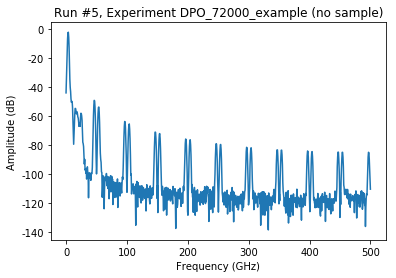

In [27]:
meas = Measurement(exp=experiment)
meas.register_parameter(math_channel.trace)

with meas.run() as datasaver:

    datasaver.add_result(
        (math_channel.trace_axis, math_channel.trace_axis()),
        (math_channel.trace, math_channel.trace())
    )

    dataid = datasaver.run_id

plot_by_id(dataid)

In order to fully support math operations and spectral analysis, we need code to add a math function through the QCoDeS driver, rather than manually. Additionally, we need to be able to adjust the frequency ranges and possibly other relevant parameters.

As always, contributions are more then welcome! :-)